<a href="https://colab.research.google.com/github/VavRe/data-mining-ut/blob/main/Final/Campaign_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report


In [39]:
LOCAL_DATASET_PATH = "./datasets/banking.csv"
COLAB_DATASET_PATH =  "/content/drive/MyDrive/DM/banking.csv"
DATASET_PATH = LOCAL_DATASET_PATH

In [40]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    DATASET_PATH = COLAB_DATASET_PATH

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:

df = pd.read_csv(DATASET_PATH)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp_var_rate    41188 non-null  float64
 16  cons_price_idx  41188 non-null  float64
 17  cons_conf_idx   41188 non-null 

<Axes: >

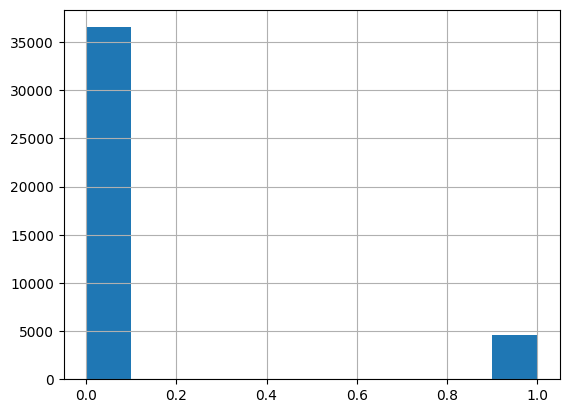

In [ ]:
df['y'].hist()

In [ ]:
# Check for null values
df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp_var_rate      0
cons_price_idx    0
cons_conf_idx     0
euribor3m         0
nr_employed       0
y                 0
dtype: int64

In [ ]:
# # Find the t-SNE for samples as row with all columns except y column and use y as color in plot using seaborn
# from sklearn.manifold import TSNE
# tsne = TSNE(n_components=2, random_state=101)
# tsne_data = tsne.fit_transform(X_train)

# tsne_df = pd.DataFrame(tsne_data, columns=['tsne1', 'tsne2'])
# tsne_df['y'] = y_train.values

# plt.figure(figsize=(10, 10))
# sns.scatterplot(x='tsne1', y='tsne2', hue='y', data=tsne_df)
# plt.show()




<ipython-input-7-778be0c76eca>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


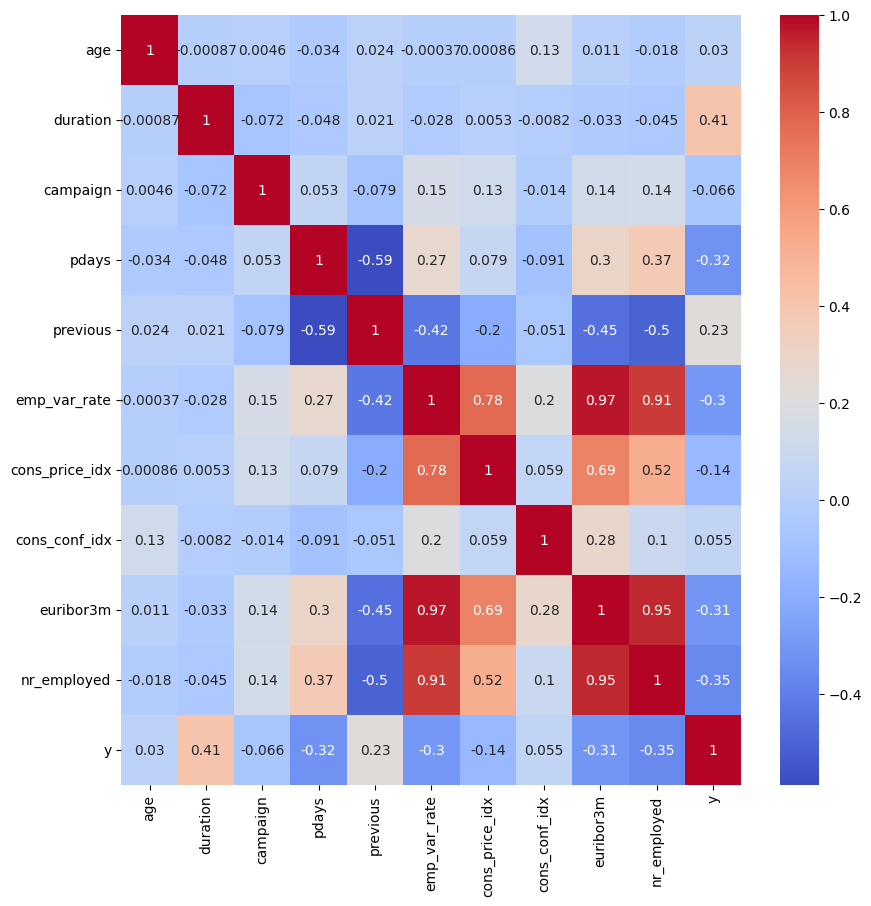

In [ ]:
corr = df.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.show()


In [42]:
# Drop euribor3m column and nr_employed column

df.drop(['euribor3m', 'nr_employed'], axis=1, inplace=True)

In [43]:
# Print every categorical column and their unique values
count = 0
for indx, col in enumerate(df.select_dtypes(include=['object']).columns):
    print(f"{col} => {df[col].unique()}")
    count += 1

print(f"Total categorical columns : {count}")

job => ['blue-collar' 'technician' 'management' 'services' 'retired' 'admin.'
 'housemaid' 'unemployed' 'entrepreneur' 'self-employed' 'unknown'
 'student']
marital => ['married' 'single' 'divorced' 'unknown']
education => ['basic.4y' 'unknown' 'university.degree' 'high.school' 'basic.9y'
 'professional.course' 'basic.6y' 'illiterate']
default => ['unknown' 'no' 'yes']
housing => ['yes' 'no' 'unknown']
loan => ['no' 'yes' 'unknown']
contact => ['cellular' 'telephone']
month => ['aug' 'nov' 'jun' 'apr' 'jul' 'may' 'oct' 'mar' 'sep' 'dec']
day_of_week => ['thu' 'fri' 'tue' 'mon' 'wed']
poutcome => ['nonexistent' 'success' 'failure']
Total categorical columns : 10


In [44]:
# Remove Outliers, For Each float type value, find the first and third quantile, and remove the values that are outside of 1.5 times of the interquantile range
for col in df.select_dtypes(include=['float64']).columns:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = round(q3 - q1, 3)
    print(f"{col} => , q1 : {q1}, q3 : {q3}, iqr : {iqr}")
    # print the number of outliers removed
    before = df.shape[0]
    df = df[(df[col] >= q1 - 1.5 * iqr) & (df[col] <= q3 + 1.5 * iqr)]
    print(f"Outliers removed : {before - df.shape[0]}")

emp_var_rate => , q1 : -1.8, q3 : 1.4, iqr : 3.2
Outliers removed : 0
cons_price_idx => , q1 : 93.075, q3 : 93.994, iqr : 0.919
Outliers removed : 0
cons_conf_idx => , q1 : -42.7, q3 : -36.4, iqr : 6.3
Outliers removed : 447


In [ ]:
# STRATEGY 1: Remove Outliers, Standardize the data and remove most correlated features, Then -1, 0, 1 encode the triary features and Ordinal encode other categorical Features
# STRATEGY 2: Remove Outliers, OneHot Encode all categorical features, then standardize and minmaxscale the data and select 20 best features using SelectKBest
# STRATEGY 3: Remove Outliers, OneHot Encode all categorical features, then minmaxscale the data and select 20 best features using SelectKBest

In [45]:
from sklearn.preprocessing import MinMaxScaler

def min_max_scale_data(df):

    print(30*"=", "Starting MinMax Scaling to the range of 0 to 1", 30*"=")
    scaler = MinMaxScaler()
    for col in df.select_dtypes(include=['float64']).columns:
        df[col] = scaler.fit_transform(df[[col]])

    return df

In [46]:
def standardize_data(df):

    print(30*"=", "Standardizing the float data type cols and print which cols are standardized and their mean and std before and after standardization", 30*"=")
    for col in df.select_dtypes(include=['float64']).columns:
        print(f"{col} => mean : {df[col].mean()}, std : {df[col].std()}")
        scaler = StandardScaler()
        df[col] = scaler.fit_transform(df[[col]])
        print(f"{col} => mean : {df[col].mean()}, std : {df[col].std()}")

    return df

In [47]:
from sklearn.feature_selection import SelectKBest, chi2

def select_k_best_features(df,k):

    # Select 10 best features for dataset using SelectKBest
    print(30*"=", "Starting to select {k} best features for dataset using SelectKBest", 30*"=")
    X = df.drop('y', axis=1)
    y = df['y']

    bestfeatures = SelectKBest(score_func=chi2, k=10)
    fit = bestfeatures.fit(X, y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)

    featureScores = pd.concat([dfcolumns, dfscores], axis=1)
    featureScores.columns = ['Specs', 'Score']
    print("{K} best features are : ")
    print(featureScores.nlargest(k, 'Score'))

    best_cols = featureScores.nlargest(k, 'Score')['Specs'].values

    # Delete the columns that are not in the best_cols
    print("Removing the columns that are not in the best_cols")
    for col in df.columns:
        if col not in best_cols and col != 'y':
            print("Removing col : ", col)
            df.drop(col, axis=1, inplace=True)

    return df, featureScores

In [48]:
def custom_categorical_encoding(df):

    print(30*"=","Starting Make Categorical Features Numeric using Hand Picked Ordinal and Binary Encoding", 30*"=")
    df['job'] = df['job'].map({'admin.': 0, 'blue-collar': 1, 'technician': 2, 'services': 3, 'management': 4, 'retired': 5, 'entrepreneur': 6, 'self-employed': 7, 'housemaid': 8, 'unemployed': 9, 'student': 10, 'unknown': 11})
    df['marital'] = df['marital'].map({'single': 0, 'married': 1, 'divorced': 2, 'unknown': 3})
    df['education'] = df['education'].map({'university.degree': 0, 'high.school': 1, 'basic.9y': 2, 'professional.course': 3, 'basic.4y': 4, 'basic.6y': 5, 'illiterate': 6, 'unknown': 7})
    df['default'] = df['default'].map({'no': -1, 'yes': 1, 'unknown': 0})
    df['housing'] = df['housing'].map({'no': -1, 'yes': 1, 'unknown': 0})
    df['loan'] = df['loan'].map({'no': 0, 'yes': 1, 'unknown': 0})
    df['contact'] = df['contact'].map({'cellular': 0, 'telephone': 1})
    df['month'] = df['month'].map({'may': 0, 'jul': 1, 'aug': 2, 'jun': 3, 'nov': 4, 'apr': 5, 'oct': 6, 'sep': 7, 'mar': 8, 'dec': 9})
    df['day_of_week'] = df['day_of_week'].map({'thu': 0, 'mon': 1, 'wed': 2, 'tue': 3, 'fri': 4})
    df['poutcome'] = df['poutcome'].map({'nonexistent': 0, 'failure': -1, 'success': 1})
    df['y'] = df['y'].map({'no': 0, 'yes': 1})

    return df

In [49]:
# Standardize the float data type cols and print which cols are standardized and their mean and std before and after standardization
def preprocess(df, STRATEGY=1):
    inner_df = df.copy()
    if STRATEGY == 1:
        print("="*50 ,"Strating Strategy 1", "=" * 50)
        standardized_df = standardize_data(inner_df)
        custom_categorized_df = custom_categorical_encoding(standardized_df)
        print("="*50 ,"Ending Strategy 1", "=" * 50)
        return custom_categorized_df

    if STRATEGY == 2:
        print("="*50 ,"Strating Strategy 2", "=" * 50)
        standardized_df = standardize_data(inner_df)
        one_hot_encoded_df = pd.get_dummies(standardized_df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'], drop_first=True)
        min_max_scaled_df = min_max_scale_data(one_hot_encoded_df)
        k_best_features_df, feature_scores = select_k_best_features(min_max_scaled_df, 20)
        print("="*50 ,"Ending Strategy 2", "=" * 50)
        return k_best_features_df

    if STRATEGY == 3:
        print("="*50 ,"Strating Strategy 3", "=" * 50)
        one_hot_encoded_df = pd.get_dummies(inner_df, columns=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome'], drop_first=True)
        min_max_scaled_df = min_max_scale_data(one_hot_encoded_df)
        k_best_features_df, feature_scores = select_k_best_features(min_max_scaled_df, 20)
        print("="*50 ,"Ending Strategy 3", "=" * 50)
        return min_max_scaled_df





In [71]:
# Train Test Split
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

def preprocess_and_train_pipeline(df, STRATEGY=3):

  df = preprocess(df, STRATEGY)
  X = df.drop('y', axis=1)
  y = df['y']
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

  param_grid = {'kernel': ['rbf', 'poly', 'linear']}
  scoring = ['f1_macro', 'accuracy','f1_micro']
  grid = GridSearchCV(SVC(), param_grid, refit='f1_micro', verbose=3, cv=4, scoring=scoring)
  grid.fit(X_train, y_train)
  grid_predictions = grid.predict(X_test)
  print(classification_report(y_test, grid_predictions))

  return grid, df


In [69]:
# Write a Cross Validation function to find the best hyperparameters for the SVM model searching for different kernels

s3_grid , s3_df = preprocess_and_train_pipeline(df,STRATEGY=3)


================================================== Strating Strategy 3 ==================================================
============================== Starting MinMax Scaling to the range of 0 to 1 ==============================
============================== Starting to select {k} best features for dataset using SelectKBest ==============================
{K} best features are : 
                          Specs         Score
1                      duration  1.792457e+06
3                         pdays  1.489313e+05
50             poutcome_success  3.915181e+03
4                      previous  3.026637e+03
40                    month_mar  8.783782e+02
44                    month_sep  6.745115e+02
35            contact_telephone  5.164539e+02
2                      campaign  4.962696e+02
5                  emp_var_rate  4.751453e+02
43                    month_oct  4.199616e+02
15                  job_student  3.323368e+02
12                  job_retired  3.061382e+02
29              d

KeyboardInterrupt: ignored

In [ ]:
s2_grid , s2_df = preprocess_and_train_pipeline(df,STRATEGY=2)

================================================== Strating Strategy 2 ==================================================
============================== Standardizing the float data type cols and print which cols are standardized and their mean and std before and after standardization ==============================
emp_var_rate => mean : 0.12008787216808621, std : 1.5363962712601562
emp_var_rate => mean : -3.662501522044649e-18, std : 1.0000122728751055
cons_price_idx => mean : 93.58822333766967, std : 0.5693840103336479
cons_price_idx => mean : -5.595604706346691e-15, std : 1.0000122728751055
cons_conf_idx => mean : -40.65184457917086, std : 4.427505333996714
cons_conf_idx => mean : 6.156490653722671e-16, std : 1.0000122728751055
============================== Starting MinMax Scaling to the range of 0 to 1 ==============================
============================== Starting to select {k} best features for dataset using SelectKBest ==============================
{K} best features are

In [ ]:
s1_grid, s1_df = preprocess_and_train_pipeline(df,STRATEGY=1)

================================================== Strating Strategy 3 ==================================================
============================== Starting MinMax Scaling to the range of 0 to 1 ==============================
============================== Starting to select {k} best features for dataset using SelectKBest ==============================
{K} best features are : 
                          Specs         Score
1                      duration  1.792457e+06
3                         pdays  1.489313e+05
50             poutcome_success  3.915181e+03
4                      previous  3.026637e+03
40                    month_mar  8.783782e+02
44                    month_sep  6.745115e+02
35            contact_telephone  5.164539e+02
2                      campaign  4.962696e+02
5                  emp_var_rate  4.751453e+02
43                    month_oct  4.199616e+02
15                  job_student  3.323368e+02
12                  job_retired  3.061382e+02
29              d

In [54]:
!pip install pyarc
!pip install scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [63]:
BEST_STRATEGY = 3

best_df = preprocess(df, BEST_STRATEGY)

X = best_df.drop('y', axis=1)
y = best_df['y']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

================================================== Strating Strategy 3 ==================================================
============================== Starting MinMax Scaling to the range of 0 to 1 ==============================
============================== Starting to select {k} best features for dataset using SelectKBest ==============================
{K} best features are : 
                          Specs         Score
1                      duration  1.792457e+06
3                         pdays  1.489313e+05
50             poutcome_success  3.915181e+03
4                      previous  3.026637e+03
40                    month_mar  8.783782e+02
44                    month_sep  6.745115e+02
35            contact_telephone  5.164539e+02
2                      campaign  4.962696e+02
5                  emp_var_rate  4.751453e+02
43                    month_oct  4.199616e+02
15                  job_student  3.323368e+02
12                  job_retired  3.061382e+02
29              d

In [66]:
# Implenet and test dummy classifier with uniform strategy
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier(strategy='uniform')

dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.50      0.64      7257
           1       0.11      0.52      0.18       892

    accuracy                           0.50      8149
   macro avg       0.50      0.51      0.41      8149
weighted avg       0.81      0.50      0.59      8149



In [64]:
# Implement a GridSearch with KFold Cross Validation of 4 MLPClassifier with hidden layer sizes of 8 , 16 , 32 , 64 scoring on f1 macro and f1 micro and accuracy

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

mlp = MLPClassifier()
param_grid = {'hidden_layer_sizes': [(8,), (16,), (32,), (64,)]}
scoring = ['f1_macro', 'accuracy','f1_micro']
grid = GridSearchCV(mlp, param_grid, refit='f1_micro', verbose=3, cv=4, scoring=scoring)
grid.fit(X_train, y_train)
grid_predictions = grid.predict(X_test)
print(classification_report(y_test, grid_predictions))


Fitting 4 folds for each of 4 candidates, totalling 16 fits
[CV 1/4] END hidden_layer_sizes=(8,); accuracy: (test=0.909) f1_macro: (test=0.767) f1_micro: (test=0.909) total time=   5.0s
[CV 2/4] END hidden_layer_sizes=(8,); accuracy: (test=0.898) f1_macro: (test=0.774) f1_micro: (test=0.898) total time=   4.3s
[CV 3/4] END hidden_layer_sizes=(8,); accuracy: (test=0.906) f1_macro: (test=0.655) f1_micro: (test=0.906) total time=   3.3s
[CV 4/4] END hidden_layer_sizes=(8,); accuracy: (test=0.912) f1_macro: (test=0.749) f1_micro: (test=0.912) total time=   3.3s
[CV 1/4] END hidden_layer_sizes=(16,); accuracy: (test=0.906) f1_macro: (test=0.656) f1_micro: (test=0.906) total time=   4.9s
[CV 2/4] END hidden_layer_sizes=(16,); accuracy: (test=0.894) f1_macro: (test=0.763) f1_micro: (test=0.894) total time=   2.8s
[CV 3/4] END hidden_layer_sizes=(16,); accuracy: (test=0.911) f1_macro: (test=0.746) f1_micro: (test=0.911) total time=   2.6s
[CV 4/4] END hidden_layer_sizes=(16,); accuracy: (test=

In [65]:
from pyarc import CBA, TransactionDB

params = {"conf":[0.5,0.7,0.9], "supp":[0.3,0.5,0.7]}
models = []

data_train = pd.concat([X_train, y_train], axis=1)
data_test = pd.concat([X_test, y_test], axis=1)

txns_train = TransactionDB.from_DataFrame(data_train)
txns_test = TransactionDB.from_DataFrame(data_test)


for supp in params["supp"]:
  for conf in params["conf"]:
    cba = CBA(support=supp, confidence=conf, algorithm="m1")
    cba.fit(txns_train)
    entry = [conf, supp, cba]
    models.append(entry)
    accuracy = cba.rule_model_accuracy(txns_test)
    print("Support: ", supp, "Confidence: ", conf, "Accuracy: ", accuracy)

Support:  0.3 Confidence:  0.5 Accuracy:  0.897410725242361
Support:  0.3 Confidence:  0.7 Accuracy:  0.897410725242361
Support:  0.3 Confidence:  0.9 Accuracy:  0.897410725242361
Support:  0.5 Confidence:  0.5 Accuracy:  0.900233157442631
Support:  0.5 Confidence:  0.7 Accuracy:  0.900233157442631
Support:  0.5 Confidence:  0.9 Accuracy:  0.900233157442631
Support:  0.7 Confidence:  0.5 Accuracy:  0.900110442999141
Support:  0.7 Confidence:  0.7 Accuracy:  0.900110442999141
Support:  0.7 Confidence:  0.9 Accuracy:  0.900110442999141
